In [1]:
import numpy as np
import collections
from math import log
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import feature_extraction
% matplotlib inline

In [2]:
# Python 3 backwards compatibility tricks
if sys.version_info.major > 2:

    def xrange(*args, **kwargs):
        return iter(range(*args, **kwargs))

    def unicode(*args, **kwargs):
        return str(*args, **kwargs)

class LangModel:
    def fit_corpus(self, corpus):
        """Learn the language model for the whole corpus.

        The corpus consists of a list of sentences."""
        for s in corpus:
            self.fit_sentence(s)
        self.norm()

    def perplexity(self, corpus):
        """Computes the perplexity of the corpus by the model.

        Assumes the model uses an EOS symbol at the end of each sentence.
        """
        return pow(2.0, self.entropy(corpus))

    def entropy(self, corpus):
        num_words = 0.0
        sum_logprob = 0.0
        for s in corpus:
            num_words += len(s) + 1 # for Linespace
            sum_logprob += self.logprob_sentence(['_LINESPACE']+s)
        return -(1.0/num_words)*(sum_logprob)

    def logprob_sentence(self, sentence):
        p = 0.0
        for i in range(1,len(sentence)):
            p += self.cond_logprob(sentence[i], sentence[:i])
        p += self.cond_logprob('_LINESPACE', sentence)
        return p

    # required, update the model when a sentence is observed
    def fit_sentence(self, sentence): pass
    # optional, if there are any post-training steps (such as normalizing probabilities)
    def norm(self): pass
    # required, return the log2 of the conditional prob of word, given previous words
    def cond_logprob(self, word, previous): pass
    # required, the list of words the language model supports (including EOS)
    def vocab(self): pass

In [3]:
class Unigram(LangModel):
    def __init__(self, backoff = 0.000001):
        self.model = dict()
        self.lbackoff = log(backoff, 2)
        
    def inc_word(self, w):
        if w in self.model:
            self.model[w] += 1.0
        else:
            self.model[w] = 1.0

    def fit_sentence(self, sentence):
        for w in sentence:
            self.inc_word(w)
        self.inc_word('_LINESPACE')

    def norm(self):
        """Normalize and convert to log2-probs."""
        tot = 0.0
        for word in self.model:
            tot += self.model[word]
        ltot = log(tot, 2)
        for word in self.model:
            self.model[word] = log(self.model[word], 2) - ltot

    def cond_logprob(self, word, previous):
        if word in self.model:
            return self.model[word]
        else:
            return self.lbackoff

    def vocab(self):
        return self.model.keys()

In [4]:
class Bigram(LangModel):
    def __init__(self, backoff = 0.000001):
        self.model = dict()
        self.lbackoff = log(backoff, 2)
        self.vocabulary = dict()
        
    def inc_word(self, w):
        if w in self.model:
            self.model[w] += 1.0
        else:
            self.model[w] = 1.0

    def fit_sentence(self, sentence):
        s = ['_LINESPACE'] + sentence + ['_LINESPACE']
        for w in s:
            self.inc_word(w)
            self.vocabulary[w] = 1
        #self.inc_word('_LINESPACE')
        
        for i in range(2,3):
            for j in range(len(s)-i+1):
                self.inc_word(tuple(s[j:j+i]))

    def cond_logprob(self, word, previous):
        if (len(previous)>=1 and tuple([previous[-1]] + [word]) in self.model):
            return log(self.model[tuple([previous[-1]] + [word])]/self.model[previous[-1]],2)
        elif word in self.model:
            return log(self.model[word]/len(self.vocabulary),2)
        else:
            return self.lbackoff

    def vocab(self):
        return self.vocabulary.keys()

In [5]:
class Trigram(LangModel):
    def __init__(self, backoff = 0.000001):
        self.model = dict()
        self.lbackoff = log(backoff, 2)
        self.vocabulary = dict()
        
    def inc_word(self, w):
        if w in self.model:
            self.model[w] += 1.0
        else:
            self.model[w] = 1.0

    def fit_sentence(self, sentence):
        s = ['_LINESPACE'] + sentence + ['_LINESPACE']
        for w in s:
            self.inc_word(w)
            self.vocabulary[w] = 1
        #self.inc_word('_LINESPACE')
        
        for i in range(2,4):
            for j in range(len(s)-i+1):
                self.inc_word(tuple(s[j:j+i]))

    def cond_logprob(self, word, previous):
        if (len(previous)>=2 and tuple(previous[-2:] + [word]) in self.model):
            return log(self.model[tuple(previous[-2:] + [word])]/self.model[tuple(previous[-2:])],2)
        elif (len(previous)>=1 and tuple([previous[-1]] + [word]) in self.model):
            return log(self.model[tuple([previous[-1]] + [word])]/self.model[previous[-1]],2)
        elif word in self.model:
            return log(self.model[word]/len(self.vocabulary),2)
        else:
            return self.lbackoff

    def vocab(self):
        return self.vocabulary.keys()

In [6]:
class Sampler:
    def __init__(self, lm, temp = 1.0):
        """Sampler for a given language model.

        Supports the use of temperature, i.e. how peaky we want to treat the
        distribution as. Temperature of 1 means no change, temperature <1 means
        less randomness (samples high probability words even more), and temp>1
        means more randomness (samples low prob words more than otherwise). See
        simulated annealing for what this means.
        """
        self.lm = lm
        self.rnd = random.Random()
        self.temp = temp

    def sample_sentence(self, prefix = [], max_length = 20):
        """Sample a random sentence (list of words) from the language model.

        Samples words till either EOS symbol is sampled or max_length is reached.
        Does not make any assumptions about the length of the context.
        """
        i = 0
        sent = prefix
        word = self.sample_next(sent, False)
        while i <= max_length and word != "_LINESPACE":
            sent.append(word)
            word = self.sample_next(sent)
            i += 1
        return sent

    def sample_next(self, prev, incl_eos = True):
        """Samples a single word from context.

        Can be useful to debug the model, for example if you have a bigram model,
        and know the probability of X-Y should be really high, you can run
        sample_next([Y]) to see how often X get generated.

        incl_eos determines whether the space of words should include EOS or not.
        """
        wps = []
        tot = -np.inf # this is the log (total mass)
        for w in self.lm.vocab():
            if not incl_eos and w == "_LINESPACE":
                continue
                
            lp = self.lm.cond_logprob(w, prev)
            #wps.append([w, lp/self.temp])
            wps.append([w, lp])
            tot = np.logaddexp2(lp, tot)
        p = self.rnd.random()
        word = self.rnd.choice(wps)[0]
        s = -np.inf # running mass
        for w,lp in wps:
            s = np.logaddexp2(s, lp)
            if p < pow(2, s-tot):
                word = w
                break
        return word

In [7]:
def textToTokens(text):
    """Converts input string to a corpus of tokenized sentences.

    Assumes that the sentences are divided by newlines (but will ignore empty sentences).
    You can use this to try out your own datasets, but is not needed for reading the homework data.
    """
    corpus = []
    sents = text.split("\n")
    from sklearn.feature_extraction.text import CountVectorizer
    count_vect = CountVectorizer()
    count_vect.fit(sents)
    tokenizer = count_vect.build_tokenizer()
    for s in sents:
        toks = tokenizer(s)
        if len(toks) > 0:
            corpus.append(toks)
    return corpus

def file_splitter(filename, seed = 0, train_prop = 0.7, dev_prop = 0.15,
    test_prop = 0.15):
    """Splits the lines of a file into 3 output files."""
    import random
    rnd = random.Random(seed)
    basename = filename[:-4]
    train_file = open(basename + ".train.txt", "w")
    test_file = open(basename + ".test.txt", "w")
    dev_file = open(basename + ".dev.txt", "w")
    with open(filename, 'r') as f:
        for l in f.readlines():
            p = rnd.random()
            if p < train_prop:
                train_file.write(l)
            elif p < train_prop + dev_prop:
                dev_file.write(l)
            else:
                test_file.write(l)
    train_file.close()
    test_file.close()
    dev_file.close()

def read_texts(tarfname, dname):
    """Read the data from the homework data file.

    Given the location of the data archive file and the name of the
    dataset (one of brown, reuters, or gutenberg), this returns a
    data object containing train, test, and dev data. Each is a list
    of sentences, where each sentence is a sequence of tokens.
    """
    import tarfile
    tar = tarfile.open(tarfname, "r:gz", errors = 'replace')
    train_mem = tar.getmember(dname + ".train.txt")
    train_txt = unicode(tar.extractfile(train_mem).read(), errors='replace')
    test_mem = tar.getmember(dname + ".test.txt")
    test_txt = unicode(tar.extractfile(test_mem).read(), errors='replace')
    dev_mem = tar.getmember(dname + ".dev.txt")
    dev_txt = unicode(tar.extractfile(dev_mem).read(), errors='replace')

    from sklearn.feature_extraction.text import CountVectorizer
    count_vect = CountVectorizer()
    count_vect.fit(train_txt.split("\n"))
    tokenizer = count_vect.build_tokenizer()
    class Data: pass
    data = Data()
    data.train = []
    for s in train_txt.split("\n"):
        toks = tokenizer(s)
        if len(toks) > 0:
            data.train.append(toks)
    data.test = []
    for s in test_txt.split("\n"):
        toks = tokenizer(s)
        if len(toks) > 0:
            data.test.append(toks)
    data.dev = []
    for s in dev_txt.split("\n"):
        toks = tokenizer(s)
        if len(toks) > 0:
            data.dev.append(toks)
    print(dname," read.", "train:", len(data.train), "dev:", len(data.dev), "test:", len(data.test))
    return data

def learn_unigram(data):
    """Learns a unigram model from data.train.

    It also evaluates the model on data.dev and data.test, along with generating
    some sample sentences from the model.
    """
    unigram = Unigram()
    unigram.fit_corpus(data.train)
    print("vocab:", len(unigram.vocab()))
    # evaluate on train, test, and dev
#     print("train:", unigram.perplexity(data.train))
#     print("dev  :", unigram.perplexity(data.dev))
#     print("test :", unigram.perplexity(data.test))
#     sampler = Sampler(unigram)
#     print("sample: ", " ".join(str(x) for x in sampler.sample_sentence([])))
#     print("sample: ", " ".join(str(x) for x in sampler.sample_sentence([])))
#     print("sample: ", " ".join(str(x) for x in sampler.sample_sentence([])))
    return unigram

def print_table(table, row_names, col_names, latex_file = None):
    """Pretty prints the table given the table, and row and col names.

    If a latex_file is provided (and tabulate is installed), it also writes a
    file containing the LaTeX source of the table (which you can \input into your report)
    """
    try:
        from tabulate import tabulate
        rows = map(lambda r,t: [r] + t, row_names,table.tolist())
        print(tabulate(rows, headers = [""] + col_names))
        if latex_file is not None:
            latex_str = tabulate(rows, headers = [""] + col_names, tablefmt="latex")
            with open(latex_file, 'w') as f:
                f.write(latex_str)
                f.close()
    except ImportError as e:
        row_format ="{:>15} " * (len(col_names) + 1)
        print(row_format.format("", *col_names))
        for row_name, row in zip(row_names, table):
            print(row_format.format(row_name, *row))

In [8]:
dnames = ["brown", "reuters", "gutenberg"]
datas = []
# Learn the models for each of the domains, and evaluate it
for dname in dnames:
    print("-----------------------")
    print(dname)
    data = read_texts("/Users/adityajoshi/UCI/Stats NLP/Language modeling/hw2.gz", dname)
    datas.append(data)

-----------------------
brown
('brown', ' read.', 'train:', 39802, 'dev:', 8437, 'test:', 8533)
-----------------------
reuters
('reuters', ' read.', 'train:', 38183, 'dev:', 8083, 'test:', 8199)
-----------------------
gutenberg
('gutenberg', ' read.', 'train:', 68767, 'dev:', 14667, 'test:', 14861)


In [9]:
unigram = Unigram()
corpus = [
    [ "Madam", "I", "am", "your", "only", "adam" ]
]
unigram.fit_corpus(corpus)
print(unigram.model)
sampler = Sampler(unigram)
for i in xrange(10):
    print(i, ":", " ".join(str(x) for x in sampler.sample_sentence([])))

{'Madam': -2.807354922057604, '_LINESPACE': -2.807354922057604, 'I': -2.807354922057604, 'am': -2.807354922057604, 'only': -2.807354922057604, 'adam': -2.807354922057604, 'your': -2.807354922057604}
(0, ':', 'am Madam am your I Madam am adam I your am your adam adam your Madam only your adam am')
(1, ':', 'Madam am I only only am only adam I Madam only am')
(2, ':', 'only adam I am I only Madam adam only')
(3, ':', 'only am I am your adam am adam')
(4, ':', 'your adam')
(5, ':', 'I I your your your adam am only only your am your adam only am Madam adam your your only am')
(6, ':', 'I am adam')
(7, ':', 'only adam')
(8, ':', 'your I your your only am am your only Madam adam I only only Madam adam am I only am')
(9, ':', 'adam am I')


In [10]:
dnames = ["brown", "reuters", "gutenberg"]
unigram_models = []
i = 0
# Learn the models for each of the domains, and evaluate it
for dname in dnames:
    print("-----------------------")
    print(dname)
    unigram_model = learn_unigram(datas[i])
    unigram_models.append(unigram_model)
    sampler = Sampler(unigram_model)
    print("sample: ", " ".join(str(x) for x in sampler.sample_sentence([])))
    i=i+1

-----------------------
brown
('vocab:', 41746)
('sample: ', 'autumn in')
-----------------------
reuters
('vocab:', 35989)
('sample: ', 'missile 000 sale said Garcia three and')
-----------------------
gutenberg
('vocab:', 43736)
('sample: ', 'is soul what one Christ from And the the Confederate')


In [11]:
unigram_train = np.zeros((3,))
unigram_dev = np.zeros((3,))
unigram_test = np.zeros((3,))

for i,dname in enumerate(dnames):
    unigram_train[i] = unigram_models[i].perplexity(datas[i].train)
    unigram_dev[i] = unigram_models[i].perplexity(datas[i].dev)
    unigram_test[i] = unigram_models[i].perplexity(datas[i].test)

In [12]:
unigram = Unigram()
unigram.fit_corpus(data.train)
print("vocab:", len(unigram.vocab()))
# evaluate on train, test, and dev
print("train:", unigram.perplexity(data.train))
print("dev  :", unigram.perplexity(data.dev))
print("test :", unigram.perplexity(data.test))
sampler = Sampler(unigram)
print("sample: ", " ".join(str(x) for x in sampler.sample_sentence([])))

('vocab:', 43736)
('train:', 981.368830109398)
('dev  :', 1012.4294581112321)
('test :', 990.082497294399)
('sample: ', 'what from MacIan not his lurchingly interest hand Winter delight places good')


In [17]:
print(unigram_test)

[ 1604.19822047  1501.45588743   990.08249729]


In [13]:
# compute the perplexity of all pairs
n = len(dnames)
perp_dev = np.zeros((n,n))
perp_test = np.zeros((n,n))
perp_train = np.zeros((n,n))
for i in xrange(n):
    for j in xrange(n):
        perp_dev[i][j] = unigram_models[i].perplexity(datas[j].dev)
        perp_test[i][j] = unigram_models[i].perplexity(datas[j].test)
        perp_train[i][j] = unigram_models[i].perplexity(datas[j].train)

print("-------------------------------")
print("x train")
print_table(perp_train, dnames, dnames, "table-train.tex")
print("-------------------------------")
print("x dev")
print_table(perp_dev, dnames, dnames, "table-dev.tex")
print("-------------------------------")
print("x test")
print_table(perp_test, dnames, dnames, "table-test.tex")

-------------------------------
x train
                          brown         reuters       gutenberg 
          brown   1513.80180085   6742.25382469   1756.18069301 
        reuters   3812.15474159   1466.87214857   4876.45027295 
      gutenberg   2619.84362239   12384.1285525   981.368830109 
-------------------------------
x dev
                          brown         reuters       gutenberg 
          brown   1589.38682257   6737.79153562   1757.90496297 
        reuters   3814.58214981   1499.69739143   4906.34381917 
      gutenberg   2606.87268467   12336.9439412   1012.42945811 
-------------------------------
x test
                          brown         reuters       gutenberg 
          brown   1604.19822047   6854.96020247   1752.54867423 
        reuters    3872.4278122   1501.45588743   4860.03120686 
      gutenberg   2628.33853321   12539.5181242   990.082497294 


[ 1513.80180085  1466.87214857   981.36883011]
[ 1589.38682257  1499.69739143  1012.42945811]
[ 1604.19822047  1501.45588743   990.08249729]


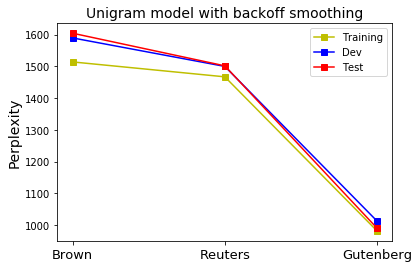

In [14]:
print(unigram_train)
print(unigram_dev)
print(unigram_test)
fig,ax = plt.subplots(1,1)
plt.title('Unigram model with backoff smoothing',fontsize=14)
plt.ylabel('Perplexity',fontsize=14)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Brown','Reuters','Gutenberg'],fontsize=13)
line1, = plt.plot(range(3),unigram_train,'ys-')
line2, = plt.plot(range(3),unigram_dev,'bs-')
line3, = plt.plot(range(3),unigram_test,'rs-')
plt.legend([line1,line2,line3],["Training","Dev","Test"])

In [20]:
### Bigram model ###

In [15]:
bigram = Bigram()
sentence = ["she","sells","sea","shells","on", "the", "sea", "shore"]
bigram.fit_sentence(sentence)
print(bigram.model)

{'on': 1.0, '_LINESPACE': 2.0, ('she', 'sells'): 1.0, 'shells': 1.0, ('on', 'the'): 1.0, ('sells', 'sea'): 1.0, ('_LINESPACE', 'she'): 1.0, 'shore': 1.0, ('sea', 'shore'): 1.0, ('sea', 'shells'): 1.0, 'she': 1.0, 'sea': 2.0, ('the', 'sea'): 1.0, ('shore', '_LINESPACE'): 1.0, 'sells': 1.0, 'the': 1.0, ('shells', 'on'): 1.0}


In [16]:
sampler = Sampler(bigram)
print("sample: ", " ".join(str(x) for x in sampler.sample_sentence(['_LINESPACE'])[1:]))

('sample: ', 'she sells on shore')


In [17]:
bigram = Bigram()
bigram.fit_corpus(datas[2].train)
print("vocab:", len(bigram.vocab()))
# evaluate on train, test, and dev
print("train:", bigram.perplexity(datas[2].train))
print("dev  :", bigram.perplexity(datas[2].dev))
print("test :", bigram.perplexity(datas[2].test))
sampler = Sampler(bigram)
print("sample: ", " ".join(str(x) for x in sampler.sample_sentence(['_LINESPACE'])[1:]))

('vocab:', 43736)
('train:', 94.77787713305848)
('dev  :', 119.84092746968565)
('test :', 118.0666500012296)
('sample: ', 'servants me charioteer Rapiers no thou shall flesh know')


In [18]:
def learn_bigram(data):
    """Learns a bigram model from data.train.

    It also evaluates the model on data.dev and data.test, along with generating
    some sample sentences from the model.
    """
    bigram = Bigram()
    bigram.fit_corpus(data.train)
    print("vocab:", len(bigram.vocab()))
    return bigram

In [19]:
dnames = ["brown", "reuters", "gutenberg"]
bigram_backoff_models = []
i=0
# Learn the models for each of the domains, and evaluate it
for dname in dnames:
    print("-----------------------")
    print(dname)
    bigram_backoff_model = learn_bigram(datas[i])
    bigram_backoff_models.append(bigram_backoff_model)
    i = i+1

-----------------------
brown
('vocab:', 41746)
-----------------------
reuters
('vocab:', 35989)
-----------------------
gutenberg
('vocab:', 43736)


In [20]:
bigram_train = np.zeros((3,))
bigram_dev = np.zeros((3,))
bigram_test = np.zeros((3,))

for i,dname in enumerate(dnames):
    print("----------------")
    bigram_train[i] = bigram_backoff_models[i].perplexity(datas[i].train)
    bigram_dev[i] = bigram_backoff_models[i].perplexity(datas[i].dev)
    bigram_test[i] = bigram_backoff_models[i].perplexity(datas[i].test)

----------------
----------------
----------------


[ 77.47861926  52.59184978  94.77787713]
[ 171.95251754   81.96634616  119.84092747]
[ 174.01928626   80.73522048  118.06665   ]


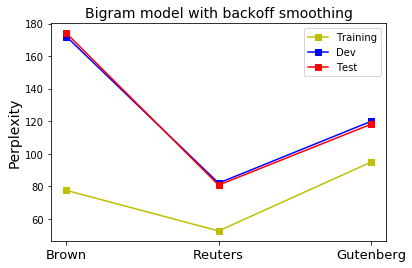

In [21]:
print(bigram_train)
print(bigram_dev)
print(bigram_test)
fig,ax = plt.subplots(1,1)
plt.title('Bigram model with backoff smoothing',fontsize=14)
plt.ylabel('Perplexity',fontsize=14)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Brown','Reuters','Gutenberg'],fontsize=13)
line1, = plt.plot(range(3),bigram_train,'ys-')
line2, = plt.plot(range(3),bigram_dev,'bs-')
line3, = plt.plot(range(3),bigram_test,'rs-')
plt.legend([line1,line2,line3],["Training","Dev","Test"])

In [22]:
# compute the perplexity of all pairs
n = len(dnames)
perp_dev = np.zeros((n,n))
perp_test = np.zeros((n,n))
perp_train = np.zeros((n,n))
for i in xrange(n):
    for j in xrange(n):
        perp_dev[i][j] = bigram_backoff_models[i].perplexity(datas[j].dev)
        perp_test[i][j] = bigram_backoff_models[i].perplexity(datas[j].test)
        perp_train[i][j] = bigram_backoff_models[i].perplexity(datas[j].train)
        
print("-------------------------------")
print("x train")
print_table(perp_train, dnames, dnames, "table-train.tex")
print("-------------------------------")
print("x dev")
print_table(perp_dev, dnames, dnames, "table-dev.tex")
print("-------------------------------")
print("x test")
print_table(perp_test, dnames, dnames, "table-test.tex")

-------------------------------
x train
                          brown         reuters       gutenberg 
          brown   77.4786192595   911.410694812   252.698501234 
        reuters   369.432941764   52.5918497805    545.65012721 
      gutenberg   295.780672256   1445.33258975   94.7778771331 
-------------------------------
x dev
                          brown         reuters       gutenberg 
          brown   171.952517537   919.521286047   252.127189673 
        reuters   372.223922797   81.9663461573   544.154337362 
      gutenberg   295.436583986   1443.51449461    119.84092747 
-------------------------------
x test
                          brown         reuters       gutenberg 
          brown    174.01928626   930.680987743   252.801889535 
        reuters   375.970996359   80.7352204811   547.301906542 
      gutenberg   296.737287763   1467.21159694   118.066650001 


In [34]:
### Trigram models ####

In [35]:
trigram = Trigram()
sentence = ["Madam","I","am","your","only", "Adam"]
trigram.fit_sentence(sentence)
print(trigram.model)

{('am', 'your', 'only'): 1.0, 'Madam': 1.0, '_LINESPACE': 2.0, ('your', 'only'): 1.0, ('only', 'Adam', '_LINESPACE'): 1.0, ('I', 'am'): 1.0, 'I': 1.0, ('I', 'am', 'your'): 1.0, ('_LINESPACE', 'Madam'): 1.0, 'am': 1.0, ('Madam', 'I'): 1.0, ('Adam', '_LINESPACE'): 1.0, 'only': 1.0, ('_LINESPACE', 'Madam', 'I'): 1.0, 'Adam': 1.0, ('am', 'your'): 1.0, ('Madam', 'I', 'am'): 1.0, ('only', 'Adam'): 1.0, ('your', 'only', 'Adam'): 1.0, 'your': 1.0}


In [36]:
trigram = Trigram()
trigram.fit_corpus(data.train)
print("vocab:", len(trigram.vocab()))
# evaluate on train, test, and dev
print("train:", trigram.perplexity(data.train))
print("dev  :", trigram.perplexity(data.dev))
print("test :", trigram.perplexity(data.test))
sampler = Sampler(trigram)
print("sample: ", " ".join(str(x) for x in sampler.sample_sentence(['_LINESPACE'])[1:]))

('vocab:', 43736)
('train:', 9.253587950170838)
('dev  :', 79.40958352863989)
('test :', 77.45264680045435)
('sample: ', 'ingenuous')


In [37]:
def learn_trigram(data):
    """Learns a trigram model from data.train.

    It also evaluates the model on data.dev and data.test, along with generating
    some sample sentences from the model.
    """
    trigram = Trigram()
    trigram.fit_corpus(data.train)
    print("vocab:", len(trigram.vocab()))
    return trigram

In [38]:
dnames = ["brown", "reuters", "gutenberg"]
trigram_backoff_models = []
i=0
# Learn the models for each of the domains, and evaluate it
for dname in dnames:
    print("-----------------------")
    print(dname)
    trigram_backoff_model = learn_trigram(datas[i])
    trigram_backoff_models.append(trigram_backoff_model)
    i = i+1

-----------------------
brown
('vocab:', 41746)
-----------------------
reuters
('vocab:', 35989)
-----------------------
gutenberg
('vocab:', 43736)


In [39]:
trigram_train = np.zeros((3,))
trigram_dev = np.zeros((3,))
trigram_test = np.zeros((3,))

for i,dname in enumerate(dnames):
    print("----------------")
    trigram_train[i] = trigram_backoff_models[i].perplexity(datas[i].train)
    trigram_dev[i] = trigram_backoff_models[i].perplexity(datas[i].dev)
    trigram_test[i] = trigram_backoff_models[i].perplexity(datas[i].test)

----------------
----------------
----------------


[ 5.94730155  6.25126112  9.25358795]
[ 137.1060932    45.4309234    79.40958353]
[ 139.157856     44.83317647   77.4526468 ]


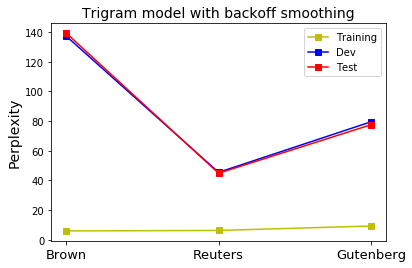

In [40]:
print(trigram_train)
print(trigram_dev)
print(trigram_test)
fig,ax = plt.subplots(1,1)
plt.title('Trigram model with backoff smoothing',fontsize=14)
plt.ylabel('Perplexity',fontsize=14)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Brown','Reuters','Gutenberg'],fontsize=13)
line1, = plt.plot(range(3),trigram_train,'ys-')
line2, = plt.plot(range(3),trigram_dev,'bs-')
line3, = plt.plot(range(3),trigram_test,'rs-')
plt.legend([line1,line2,line3],["Training","Dev","Test"])

In [41]:
# compute the perplexity of all pairs
n = len(dnames)
perp_dev = np.zeros((n,n))
perp_test = np.zeros((n,n))
perp_train = np.zeros((n,n))
for i in xrange(n):
    for j in xrange(n):
        perp_dev[i][j] = trigram_backoff_models[i].perplexity(datas[j].dev)
        perp_test[i][j] = trigram_backoff_models[i].perplexity(datas[j].test)
        perp_train[i][j] = trigram_backoff_models[i].perplexity(datas[j].train)
        
print("-------------------------------")
print("x train")
print_table(perp_train, dnames, dnames, "table-train.tex")
print("-------------------------------")
print("x dev")
print_table(perp_dev, dnames, dnames, "table-dev.tex")
print("-------------------------------")
print("x test")
print_table(perp_test, dnames, dnames, "table-test.tex")

-------------------------------
x train
                          brown         reuters       gutenberg 
          brown   5.94730155182   834.820896732   222.868837824 
        reuters   335.390109914   6.25126111739   516.736207344 
      gutenberg   259.605806368   1379.09472869   9.25358795017 
-------------------------------
x dev
                          brown         reuters       gutenberg 
          brown   137.106093202   842.667414283   222.315106611 
        reuters   338.946480781   45.4309233993   514.713160505 
      gutenberg   259.438023774   1378.70753454   79.4095835286 
-------------------------------
x test
                          brown         reuters       gutenberg 
          brown   139.157855998   854.637794359   222.389002612 
        reuters    341.73924579   44.8331764745   518.882903401 
      gutenberg   260.915481412   1402.60159855   77.4526468005 


In [25]:
#trigram model with laplace smoothing 
class Trigram_Laplace(LangModel):
    def __init__(self, l = 1):
        self.model = dict()
        self.vocabulary = dict()
        self.laplace = l
        
    def inc_word(self, w):
        if w in self.model:
            self.model[w] += 1.0
        else:
            self.model[w] = 1.0

    def fit_sentence(self, sentence):
        s = ['_LINESPACE'] + sentence + ['_LINESPACE']
        for w in s:
            self.inc_word(w)
            self.vocabulary[w] = 1
        
        s = ['_LINESPACE'] + s
        for i in range(2,4):
            for j in range(len(s)-i+1):
                self.inc_word(tuple(s[j:j+i]))
    
    def entropy(self, corpus):
        num_words = 0.0
        sum_logprob = 0.0
        for s in corpus:
            num_words += len(s) + 1 # for Linespace
            sum_logprob += self.logprob_sentence(['_LINESPACE','_LINESPACE']+s)
        return -(1.0/num_words)*(sum_logprob)

    def logprob_sentence(self, sentence):
        p = 0.0
        for i in range(2,len(sentence)):
            p += self.cond_logprob(sentence[i], sentence[:i])
        p += self.cond_logprob('_LINESPACE', sentence)
        return p
    
    def cond_logprob(self, word, previous):
        den = (self.laplace)*len(self.vocabulary)
        if (len(previous)>=2 and tuple(previous[-2:]+[word]) in self.model):
            return log((self.model[tuple(previous[-2:]+[word])]+self.laplace)/(self.model[tuple(previous[-2:])] + den),2 )
        elif (len(previous)>=2 and tuple(previous[-2:]) in self.model):
            return log(self.laplace/(self.model[tuple(previous[-2:])] + den),2)
        else:
            return log(1,2) - log(len(self.vocabulary),2)
            
    def vocab(self):
        return self.vocabulary.keys()

In [26]:
trigram = Trigram_Laplace()
corpus = [
    ["Madam","I","am","your", "Adam"]
]
trigram.fit_corpus(corpus)
print(trigram.model)
sampler = Sampler(trigram)
for i in xrange(10):
    print(i, ":", " ".join(str(x) for x in sampler.sample_sentence(['_LINESPACE', '_LINESPACE'])[2:]))

{'Madam': 1.0, '_LINESPACE': 2.0, ('Madam', 'I', 'am'): 1.0, ('_LINESPACE', '_LINESPACE'): 1.0, ('your', 'Adam', '_LINESPACE'): 1.0, ('I', 'am'): 1.0, 'I': 1.0, ('I', 'am', 'your'): 1.0, ('_LINESPACE', 'Madam'): 1.0, 'am': 1.0, ('your', 'Adam'): 1.0, ('Adam', '_LINESPACE'): 1.0, ('_LINESPACE', '_LINESPACE', 'Madam'): 1.0, ('Madam', 'I'): 1.0, ('_LINESPACE', 'Madam', 'I'): 1.0, 'Adam': 1.0, ('am', 'your'): 1.0, 'your': 1.0, ('am', 'your', 'Adam'): 1.0}
(0, ':', 'Madam your Adam your')
(1, ':', 'your Adam your your Madam')
(2, ':', 'am Adam Madam Adam Madam I Madam Adam Madam I Madam I')
(3, ':', 'Adam your')
(4, ':', 'am I I I Madam am your am Adam Madam Madam your am')
(5, ':', 'am I your am Adam Madam am am your Madam I am Madam your am your Adam Adam I am')
(6, ':', 'I Adam I am am Madam am Madam your your am')
(7, ':', 'Madam I I Adam am Adam')
(8, ':', 'Madam I am am Madam Adam')
(9, ':', 'Madam Adam I am I')


In [27]:
def learn_trigram_laplace(data, laplace=0.1):
    """Learns a trigram model from data.train.

    It also evaluates the model on data.dev and data.test, along with generating
    some sample sentences from the model.
    """
    trigram = Trigram_Laplace(laplace)
    print("l: "+str(trigram.laplace))
    trigram.fit_corpus(data.train)
    print("vocab:", len(trigram.vocab()))
    return trigram

In [28]:
L = [0.0001, 0.001, 0.002, 0.004, 0.008, 0.02, 0.04, 0.1]#, 0.16, 0.32, 0.64, 1.28]
perp_dev = np.zeros((3,len(L)))
perp_test = np.zeros((3,len(L)))
perp_train = np.zeros((3,len(L)))
# Learn the models for each of the domains, and evaluate it
for j,dname in enumerate(dnames):
    for i,l in enumerate(L):
        #print(i)
        model = learn_trigram_laplace(datas[j],l)
        perp_train[j][i] = model.perplexity(datas[j].train)
        perp_dev[j][i] = model.perplexity(datas[j].dev)
        perp_test[j][i] = model.perplexity(datas[j].test)

l: 0.0001
('vocab:', 41746)
l: 0.001
('vocab:', 41746)
l: 0.002
('vocab:', 41746)
l: 0.004
('vocab:', 41746)
l: 0.008
('vocab:', 41746)
l: 0.02
('vocab:', 41746)
l: 0.04
('vocab:', 41746)
l: 0.1
('vocab:', 41746)
l: 0.0001
('vocab:', 35989)
l: 0.001
('vocab:', 35989)
l: 0.002
('vocab:', 35989)
l: 0.004
('vocab:', 35989)
l: 0.008
('vocab:', 35989)
l: 0.02
('vocab:', 35989)
l: 0.04
('vocab:', 35989)
l: 0.1
('vocab:', 35989)
l: 0.0001
('vocab:', 43736)
l: 0.001
('vocab:', 43736)
l: 0.002
('vocab:', 43736)
l: 0.004
('vocab:', 43736)
l: 0.008
('vocab:', 43736)
l: 0.02
('vocab:', 43736)
l: 0.04
('vocab:', 43736)
l: 0.1
('vocab:', 43736)


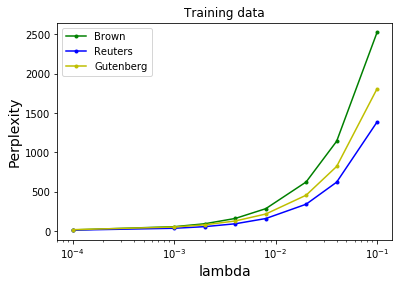

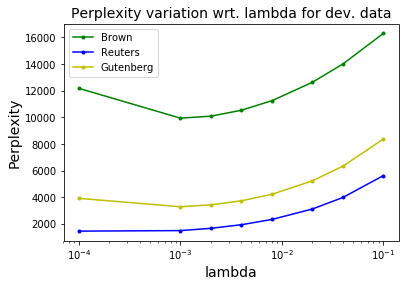

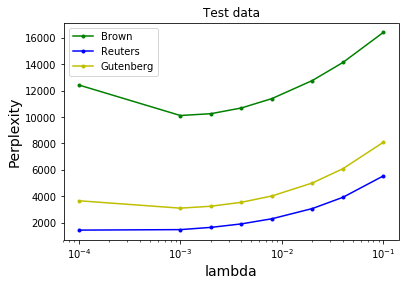

In [29]:
# plot training perp
plt.ylabel('Perplexity',fontsize=14)
plt.title('Training data')
plt.xlabel('lambda',fontsize=14)
line1, = plt.semilogx(L,perp_train[0],'g.-')
line2, = plt.semilogx(L,perp_train[1],'b.-')
line3, = plt.semilogx(L,perp_train[2],'y.-')
plt.legend([line1,line2,line3],["Brown","Reuters","Gutenberg"])
plt.show()
# plot dev perp
plt.ylabel('Perplexity',fontsize=14)
plt.title('Perplexity variation wrt. lambda for dev. data',fontsize=14)
plt.xlabel('lambda',fontsize=14)
line1, = plt.semilogx(L,perp_dev[0],'g.-')
line2, = plt.semilogx(L,perp_dev[1],'b.-')
line3, = plt.semilogx(L,perp_dev[2],'y.-')
plt.legend([line1,line2,line3],["Brown","Reuters","Gutenberg"])
plt.show()
# plot test perp
plt.ylabel('Perplexity',fontsize=14)
plt.title('Test data')
plt.xlabel('lambda',fontsize=14)
line1, = plt.semilogx(L,perp_test[0],'g.-')
line2, = plt.semilogx(L,perp_test[1],'b.-')
line3, = plt.semilogx(L,perp_test[2],'y.-')
plt.legend([line1,line2,line3],["Brown","Reuters","Gutenberg"])
plt.show()

In [30]:
dnames = ["brown", "reuters", "gutenberg"]
trigram_laplace_models = []
i=0
# Learn the models for each of the domains, and evaluate it
for dname in dnames:
    print("-----------------------")
    print(dname)
    trigram_laplace_model = learn_trigram_laplace(datas[i],0.001)
    trigram_laplace_models.append(trigram_laplace_model)
    i = i+1

-----------------------
brown
l: 0.001
('vocab:', 41746)
-----------------------
reuters
l: 0.001
('vocab:', 35989)
-----------------------
gutenberg
l: 0.001
('vocab:', 43736)


In [31]:
trigram_l_train = np.zeros((3,))
trigram_l_dev = np.zeros((3,))
trigram_l_test = np.zeros((3,))

for i,dname in enumerate(dnames):
    print("----------------")
    trigram_l_train[i] = trigram_laplace_models[i].perplexity(datas[i].train)
    trigram_l_dev[i] = trigram_laplace_models[i].perplexity(datas[i].dev)
    trigram_l_test[i] = trigram_laplace_models[i].perplexity(datas[i].test)

----------------
----------------
----------------


[ 54.34309446  34.41581736  49.90547686]
[ 9941.33661239  1493.59384163  3284.05262515]
[ 10108.45510306   1464.61266998   3089.735279  ]


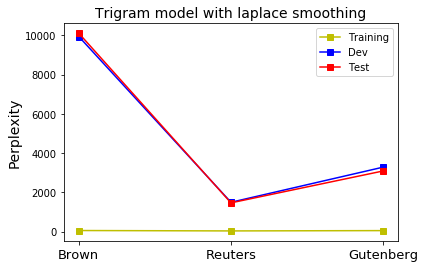

In [32]:
print(trigram_l_train)
print(trigram_l_dev)
print(trigram_l_test)
fig,ax = plt.subplots(1,1)
plt.title('Trigram model with laplace smoothing',fontsize=14)
plt.ylabel('Perplexity',fontsize=14)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Brown','Reuters','Gutenberg'],fontsize=13)
line1, = plt.plot(range(3),trigram_l_train,'ys-')
line2, = plt.plot(range(3),trigram_l_dev,'bs-')
line3, = plt.plot(range(3),trigram_l_test,'rs-')
plt.legend([line1,line2,line3],["Training","Dev","Test"])

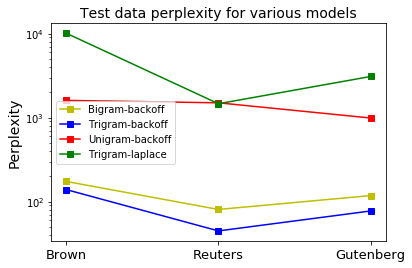

In [42]:
## comparison of all unigram, bigram and trigrams
fig,ax = plt.subplots(1,1)
plt.title('Test data perplexity for various models',fontsize=14)
plt.ylabel('Perplexity',fontsize=14)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Brown','Reuters','Gutenberg'],fontsize=13)
line1, = plt.semilogy(range(3),bigram_test,'ys-')
line2, = plt.semilogy(range(3),trigram_test,'bs-')
line3, = plt.semilogy(range(3),unigram_test,'rs-')
line4, = plt.semilogy(range(3),trigram_l_test,'gs-')
plt.legend([line1,line2,line3,line4],["Bigram-backoff","Trigram-backoff","Unigram-backoff","Trigram-laplace"],loc='best')